# NMF analysis 
 - Clustering and DEG analysis
 - Sample level frequency 

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import umap
import random
import multiprocessing
random.seed(123)
from joblib import Parallel, delayed
import warnings
import os
import gc
import math
from PIL import Image
from PIL import ImageDraw
import sc_toolbox as sct
import scanpy.external as sce

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [3]:
## reading the Non-naive CD4 Tcells that has NMF projection 
subset_a_dc=sc.read("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_Certpro_CD4_memory_Tcells_NMF.h5ad")

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
subset_a_dc

AnnData object with n_obs × n_vars = 460544 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


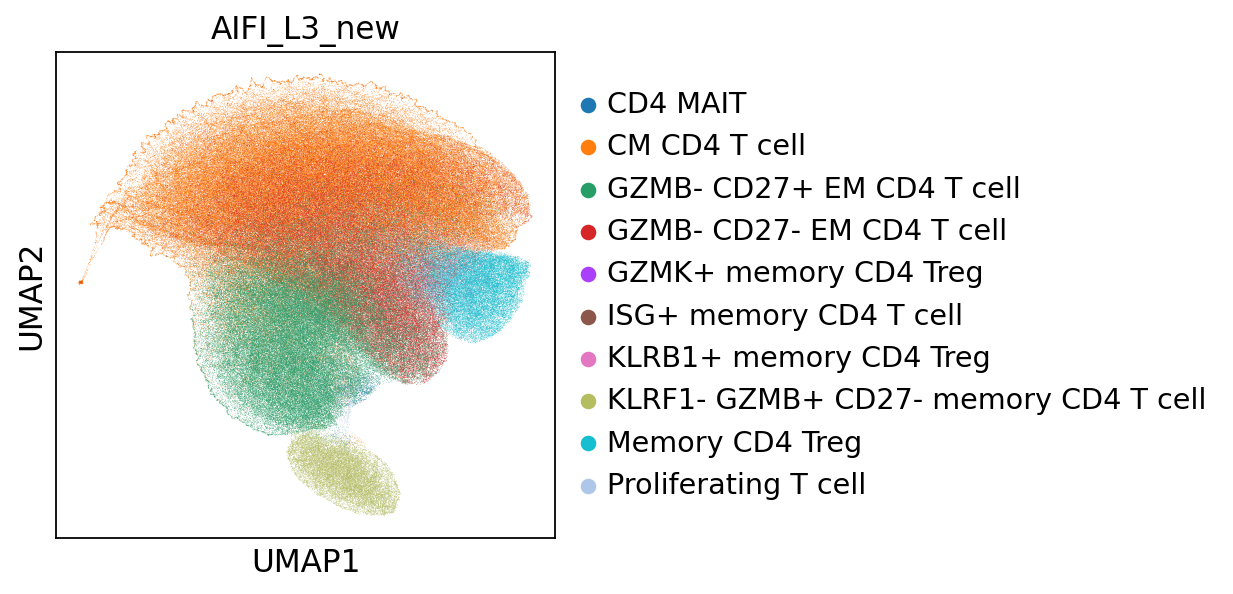

In [4]:
sc.pl.umap(subset_a_dc,color=['AIFI_L3_new'],ncols=3)

In [6]:
combined_features_NMF11 =subset_a_dc.obs[['NMF0_Cytotoxic', 'NMF1_Treg', 'NMF2_Th17', 'NMF4_Act', 'NMF5_Th2', 
                     'NMF6_Tfh', 'NMF11_Th1']]

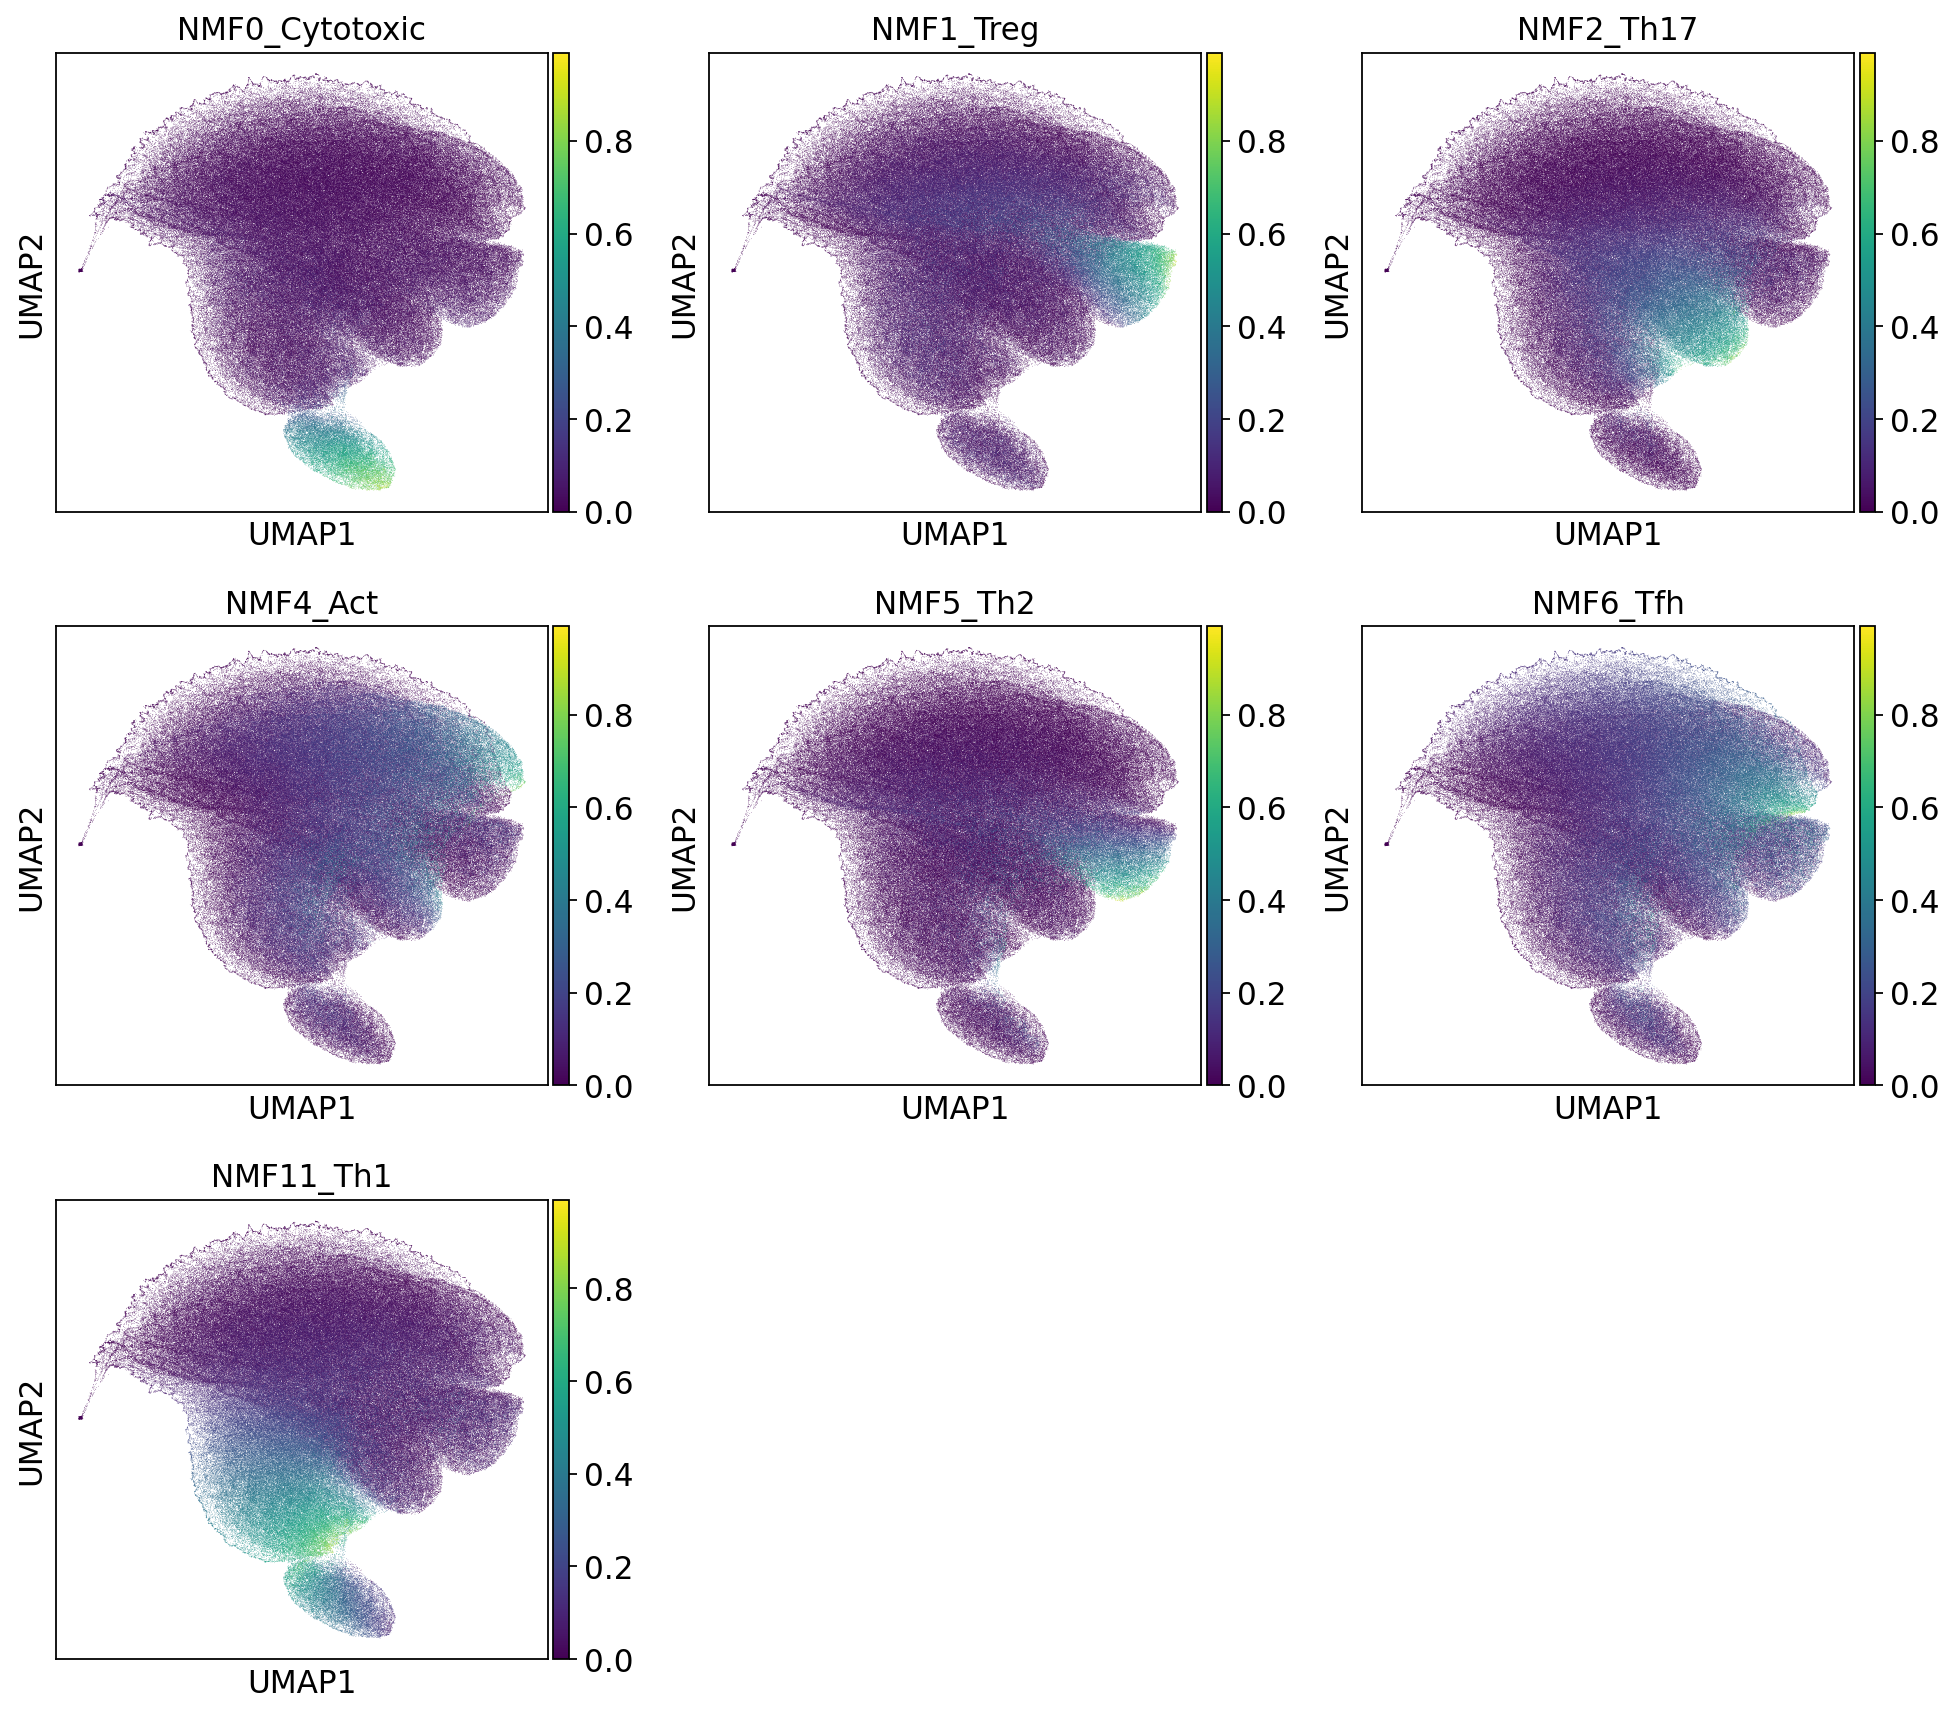

In [7]:
# Plot UMAP with adjusted color contrast
sc.pl.umap(subset_a_dc, color=combined_features_NMF11.columns, use_raw=True, ncols=3, vmax=0.99, cmap='viridis')

# Leiden clustering 


In [ ]:
# ran leiden clustering at different resolution and finalized Resolution 0.4 for downstream anlysis

In [ ]:
resolutions = [0.2, 0.3, 0.4]
for res in resolutions:
    key = f"leiden_NMF_{res}_v1"
    sc.tl.leiden(subset_a_dc, resolution=res, key_added=key, n_iterations=2, neighbors_key='NMF_neighbors_v1')

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


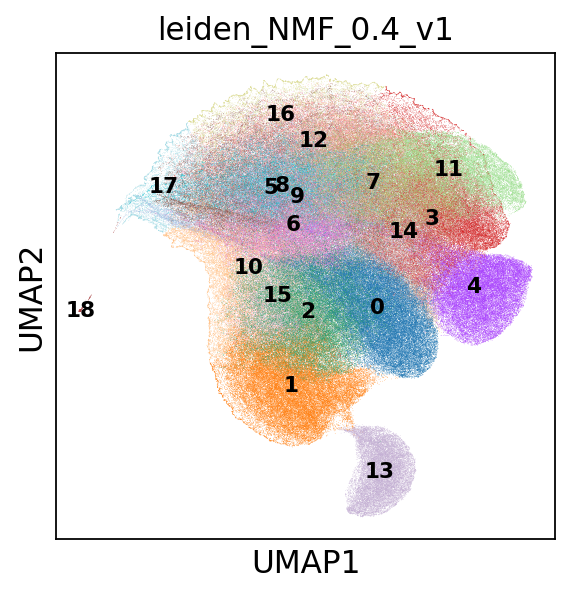

In [83]:
 sc.pl.umap(subset_a_dc, 
               color='leiden_NMF_0.4_v1',
               legend_loc='on data',
              legend_fontsize="x-small")

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


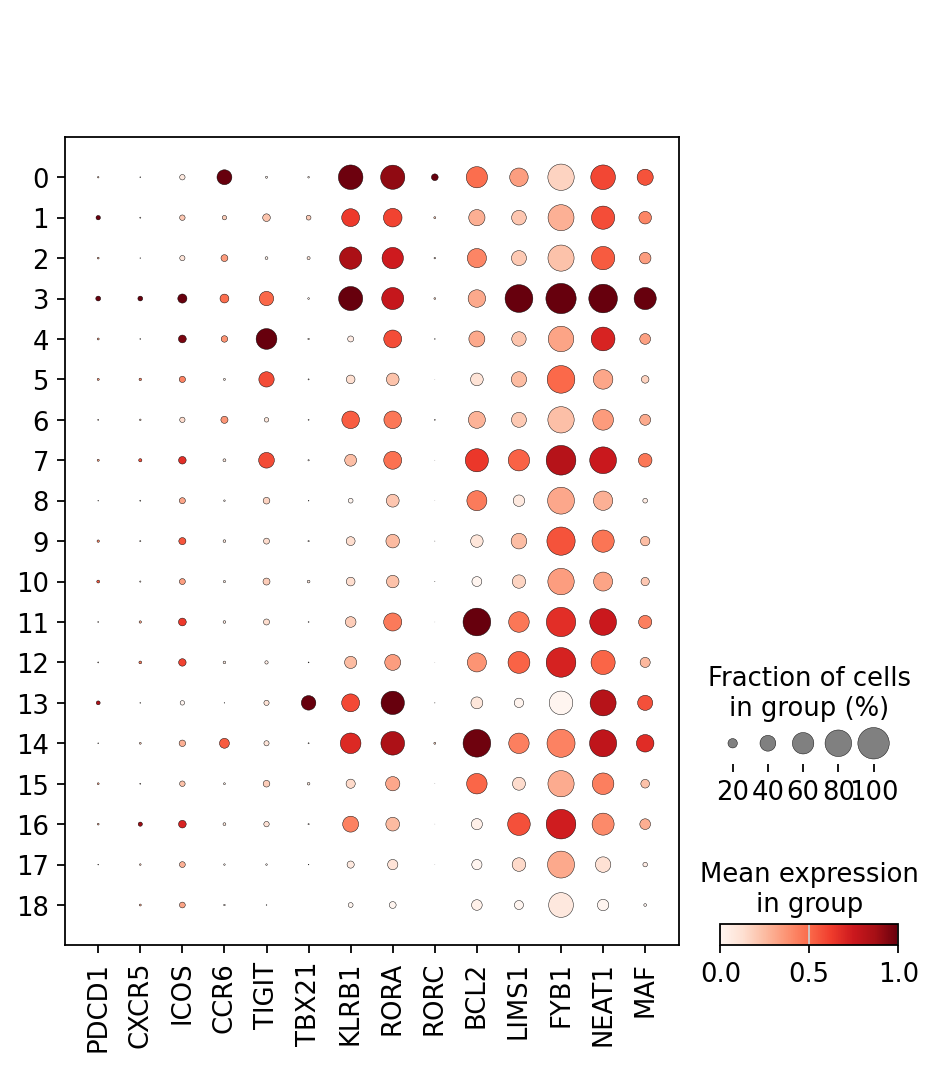

In [84]:
# Plot the dotplot for the selected clusters
sc.pl.dotplot(
    subset_a_dc, 
    ['PDCD1', 'CXCR5', 'ICOS', 'CCR6', 'TIGIT', 'TBX21', 'KLRB1', 'RORA', 'RORC', 'BCL2', 'LIMS1', 'FYB1', 'NEAT1', 'MAF'], 
    groupby='leiden_NMF_0.4_v1', 
    standard_scale='var', 
    #swap_axes=True,
    dendrogram=False
)

# Differential gene expression analysis 

In [ ]:
# DEG for res.0.4
# test for top genes that seperate the cells based on "wilcoxon
sc.tl.rank_genes_groups(subset_a_dc, groupby='leiden_NMF_0.4_v1',
                        method='wilcoxon', key_added='leiden_leiden_NMF_0.4_v1_wilcox')

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/tmp/ipykernel_3853/492808184.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('group').head(20).reset_index(drop=True)
/tmp/ipykernel_3853/492808184.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('gr

<Figure size 640x640 with 0 Axes>

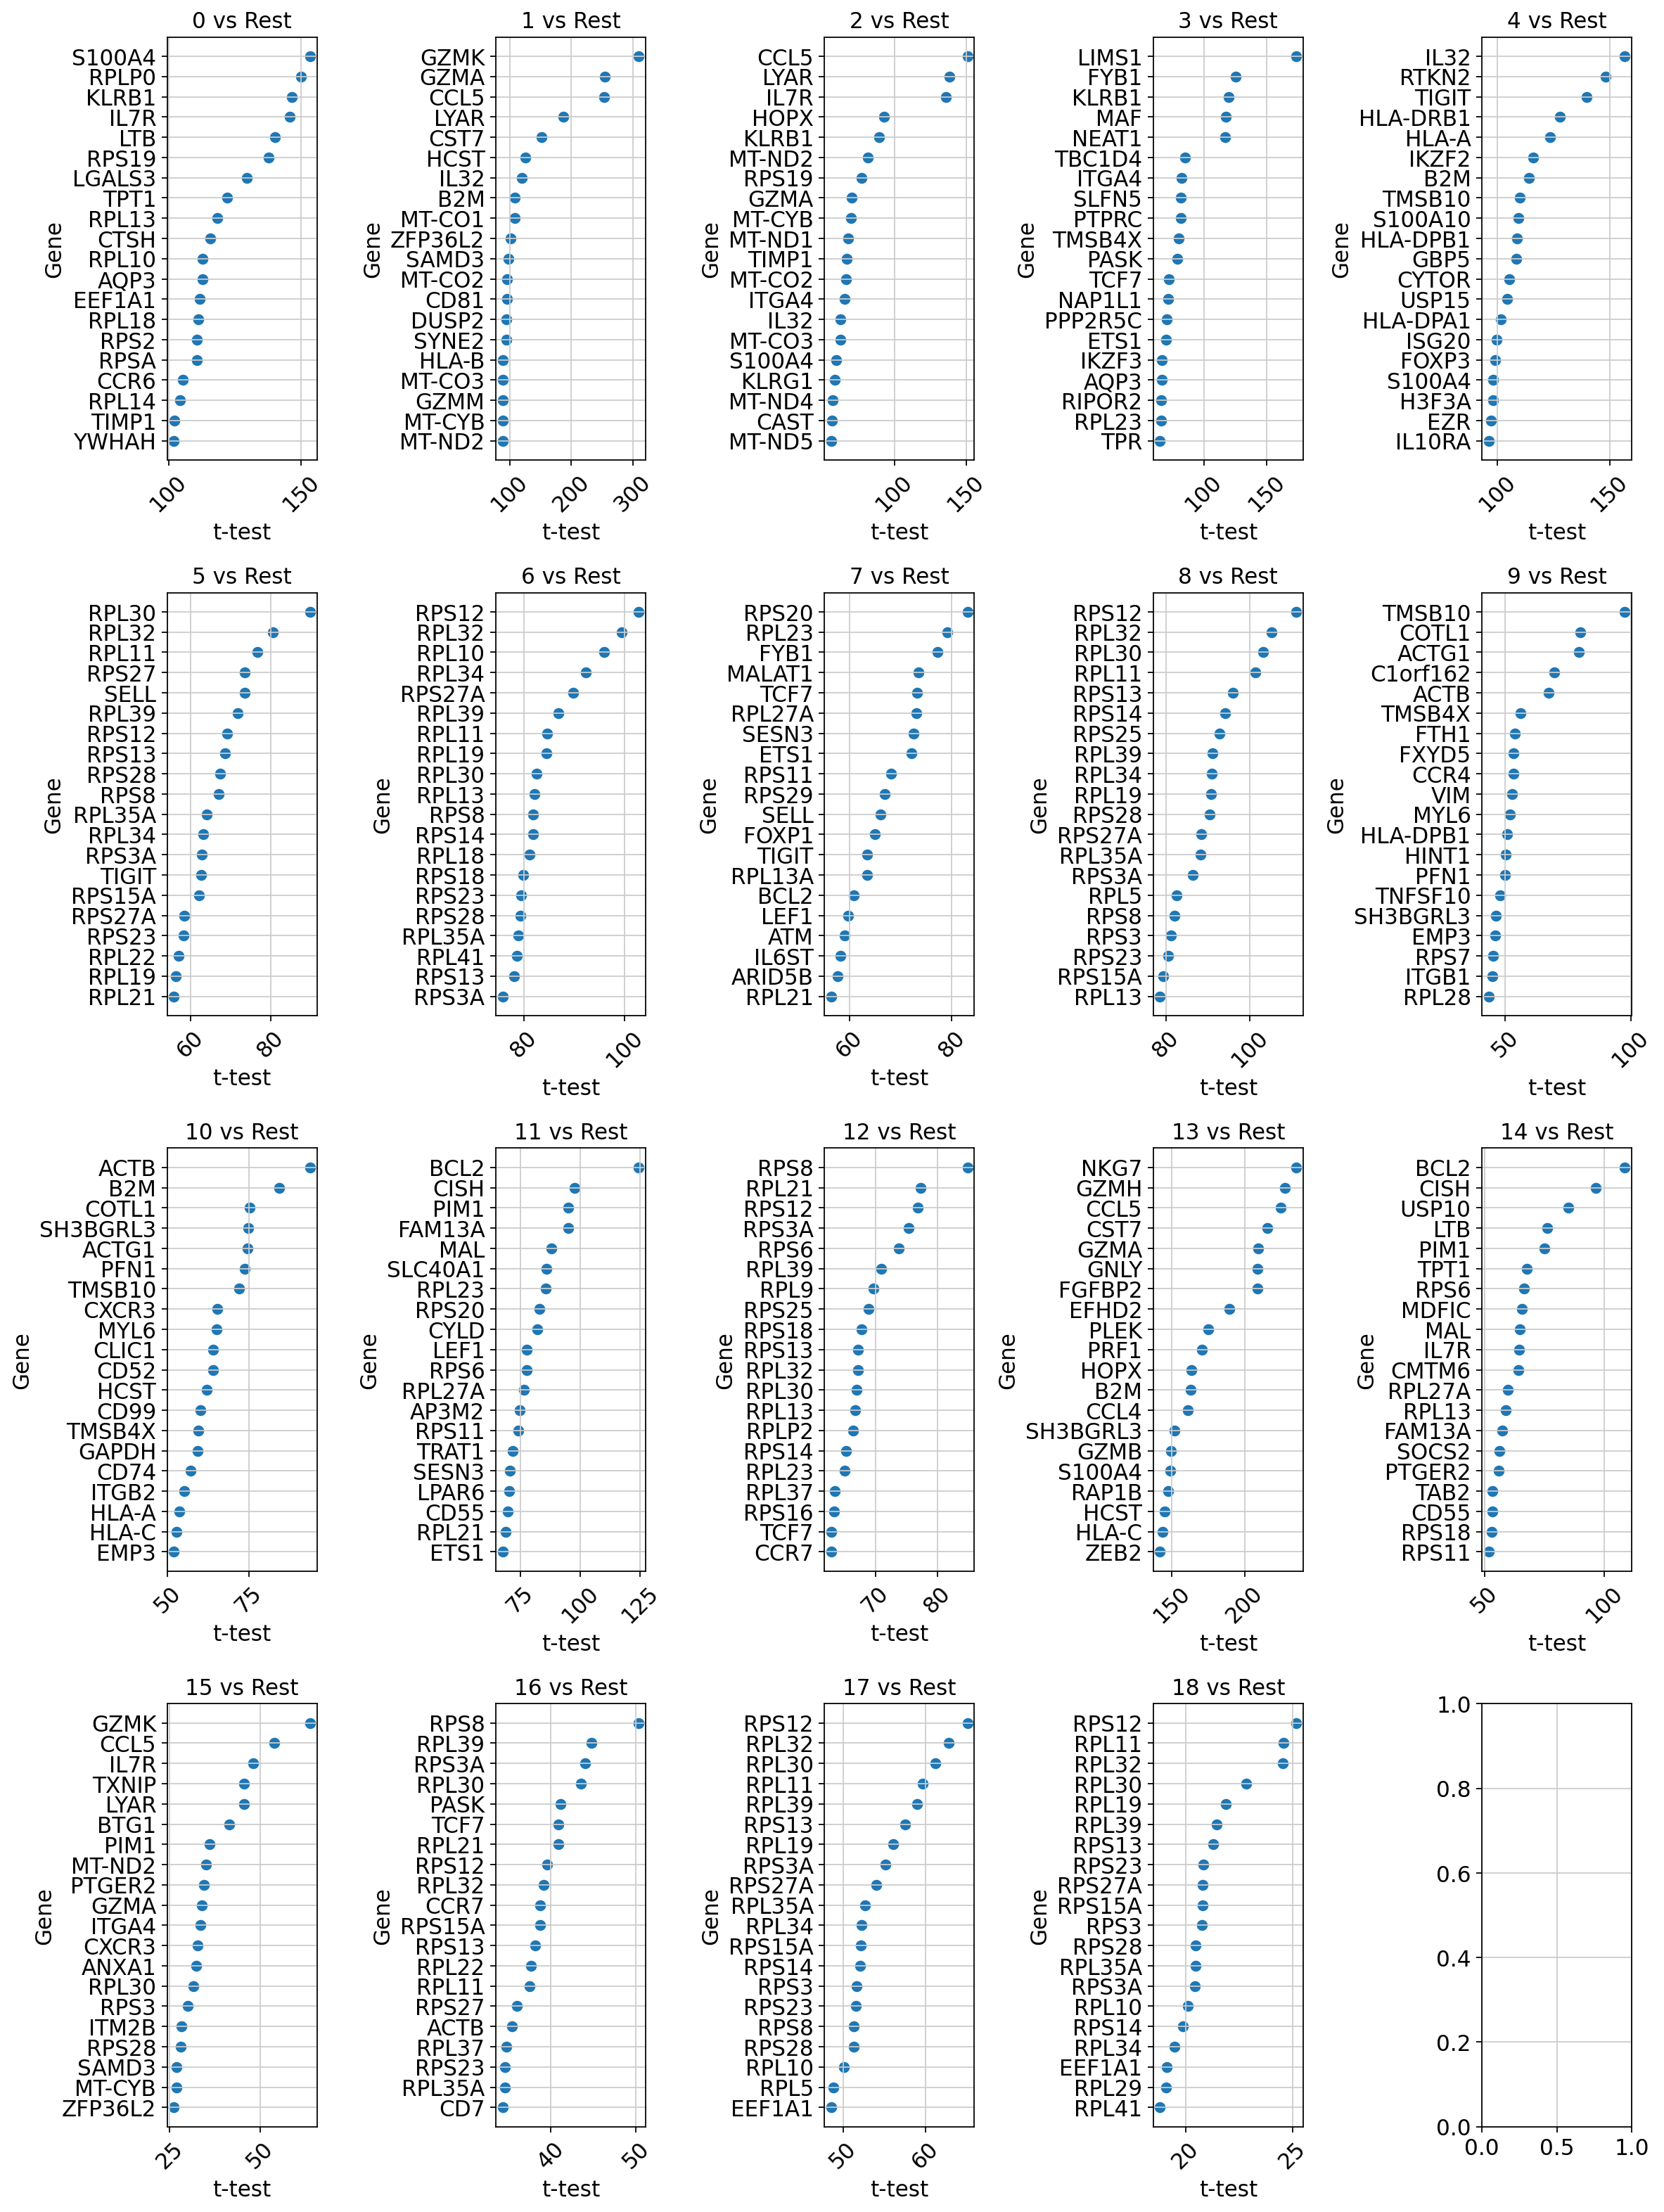

In [95]:
# Set plot size
plt.figure(figsize=(8, 8))

# Perform group-wise operations on filt_sub
df = sc.get.rank_genes_groups_df(subset_a_dc,group=None,key='leiden_leiden_NMF_0.4_v1_wilcox')
df = df.groupby('group').head(20).reset_index(drop=True)
groups = df.groupby('group')

# Calculate number of rows and columns for subplots
n_groups = len(groups)
n_cols = 5

n_rows = math.ceil(n_groups / n_cols)

# Adjust subplot width and height
subplot_width = 3 # Set the desired width for each subplot
subplot_height = 5  # Set the desired height for each subplot

# Create subplots with adjusted width and height
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * subplot_width, n_rows * subplot_height))
#fig.suptitle("CD4 T CELLS leiden_NMF_0.5_v1", fontsize=20)

if n_rows == 1:
    axs = axs.reshape(1, -1)

# Plotting for each group
for i, (name, group) in enumerate(groups):
    row, col = divmod(i, n_cols)
    ax = axs[row, col]
    ax.set_visible(True)
    ax.scatter(group['scores'], group['names'])
    ax.invert_yaxis()
    ax.set_title(str(name) + " vs Rest")
    ax.set_xlabel('t-test')
    ax.set_ylabel('Gene')

    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)  # Adjust the rotation angle as needed

plt.tight_layout()
plt.show() 

In [96]:
# output the deg list 
leiden_harmony_deg_0_4 = sc.get.rank_genes_groups_df(subset_a_dc, key='leiden_leiden_NMF_0.4_v1_wilcox',
                                              pval_cutoff=None,  group=None).rename(
    {'group':'leiden_leiden_NMF_0.4_v1_wilcox'},  axis='columns')
leiden_harmony_deg_0_4['direction'] = np.where(leiden_harmony_deg_0_4['logfoldchanges']>0, 'up', 'down')
leiden_harmony_deg_0_4 = leiden_harmony_deg_0_4.reindex(leiden_harmony_deg_0_4['scores'].abs().sort_values(ascending=False).index)

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


In [ ]:
# saving the output of DEG results

In [97]:
leiden_harmony_deg_0_4.to_csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/output_files/CD4T_mem_certpro_DEGs_res_0.4_wilcox_py.csv")

# Frequency for clusters at sample level

In [89]:
## Calculating frequency for 0.4 res
cluster_freq_0_4=sct.tools.relative_frequency_per_cluster(subset_a_dc, group_by='sample.sampleKitGuid',xlabel='leiden_NMF_0.4_v1',condition=None)

cluster_freq_0_4.to_csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/output_files/CD4T_mem_certpro_Cluster_freq_res_0.4_py.csv")

/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/sc_toolbox/tools/__init__.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frequencies = adata.obs.groupby([group_by, xlabel]).size()
/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/sc_toolbox/tools/__init__.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combinations = adata.obs.groupby([group_by, xlabel]).groups.keys()


In [90]:
cluster_freq_0_4.head()

0         1         2         3         4         5         6  \
KT00052  0.104238  0.070733  0.096220  0.068729  0.076460  0.097652  0.072738   
KT00055  0.182384  0.023676  0.051364  0.086677  0.039727  0.060594  0.097311   
KT00056  0.175741  0.047792  0.123714  0.063521  0.081972  0.065638  0.077435   
KT00057  0.121825  0.082652  0.068446  0.057254  0.084804  0.074903  0.060697   
KT00058  0.053215  0.139135  0.043237  0.091463  0.089800  0.050998  0.070399   

                7         8         9        10        11        12        13  \
KT00052  0.051260  0.063860  0.053551  0.063860  0.029782  0.046964  0.005727   
KT00055  0.054575  0.033909  0.049960  0.043138  0.029294  0.046750  0.110152   
KT00056  0.036903  0.052934  0.063521  0.062613  0.026316  0.029643  0.002722   
KT00057  0.036160  0.033577  0.084804  0.066724  0.012484  0.044339  0.102023   
KT00058  0.029933  0.033259  0.074834  0.058204  0.022727  0.047672  0.115299   

               14        15        16        17        18 sample.sampleKitGuid  
KT00052  0.029496  0.026919  0.022910  0.016609  0.002291              KT00052  
KT00055  0.043740  0.014446  0.024077  0.008226  0.000000              KT00055  
KT00056  0.037810  0.029038  0.014822  0.007864  0.000000              KT00056  
KT00057  0.011192  0.023676  0.026259  0.008179  0.000000              KT00057  
KT00058  0.017738  0.016075  0.026608  0.018293  0.001109              KT00058

In [99]:
#running density on res 0.4
sc.tl.embedding_density(subset_a_dc, basis='umap', groupby='leiden_NMF_0.4_v1')

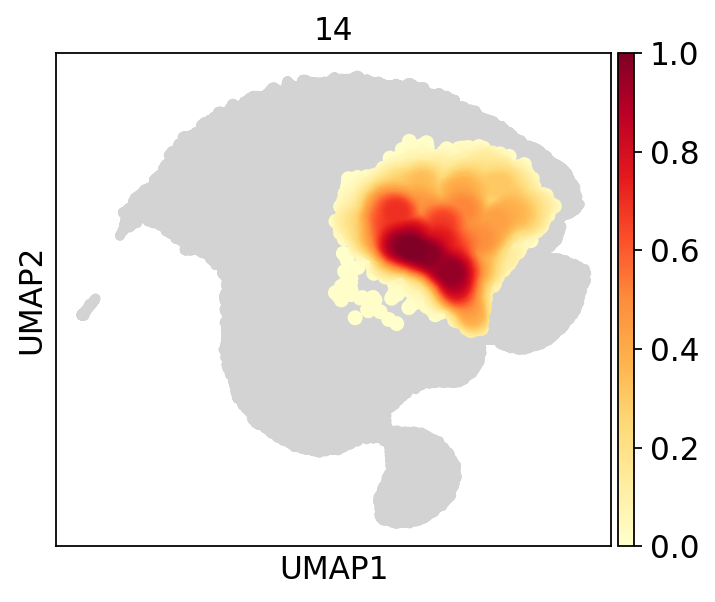

In [141]:
sc.pl.embedding_density(
    subset_a_dc, basis='umap', key='umap_density_leiden_NMF_0.4_v1',group='14'
    
)

In [92]:
# saving the anndata file with res_0.4 
subset_a_dc

AnnData object with n_obs × n_vars = 460544 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

In [103]:
subset_a_dc.write("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_certpro_CD4_memory_Tcells_NMF_res_0_4.h5ad")